In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn.svm

import optuna
import optuna.visualization

from sklearn.datasets import make_circles

# Synthetic data
X, y = make_circles(noise=0.2, factor=0.5, random_state=1)

# Overfitting and Overfitting

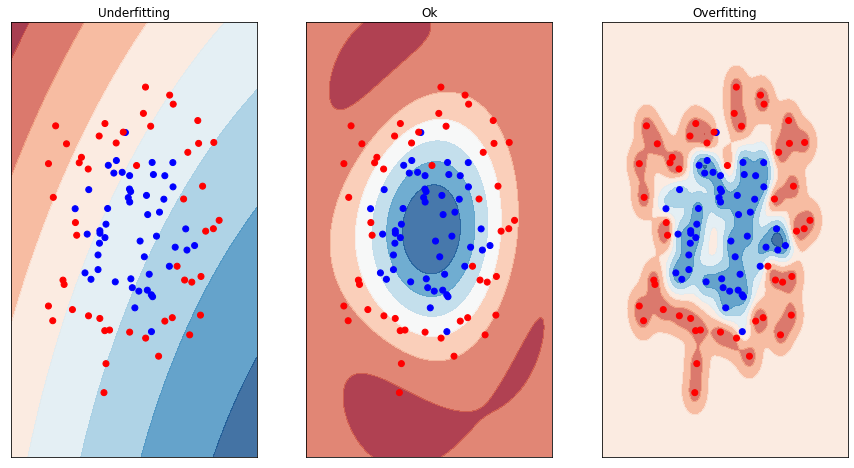

In [2]:
from sklearn.svm import SVC

RESOLUTION = 200

classifiers = [
    SVC(gamma=0.001),
    SVC(gamma=1),
    SVC(gamma=50)]
names = ["Underfitting", "Ok", "Overfitting"]

fig, axs = plt.subplots(1, len(classifiers), figsize=(15,8))

x_min, y_min = np.min(X, axis=0) - 0.5
x_max, y_max = np.max(X, axis=0) + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, RESOLUTION), np.linspace(y_min, y_max, RESOLUTION))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# iterate over classifiers
for i, (name, clf, ax) in enumerate(zip(names, classifiers, axs), start=1):
    clf.fit(X, y)

    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
plt.show()

# insipired by: https://winder.ai/overfitting-and-underfitting/

# Optimization of Hyperparameters and Overfitting
### Without Train-Test split -- how not to do it

In [3]:
def create_clf(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC",])
    
    if classifier_name == "SVC":
        # <--- C, kernel
        #C = trial.suggest_float("C", 1e-10, 1e10, log=True)
        C = trial.suggest_float("C", 1, 1, log=True)
        kernel = trial.suggest_categorical("kernel", ['rbf',])
        
        if kernel == "rbf":
            # <--- gamma
            gamma = trial.suggest_float('gamma', 1e-5, 500, log=True)
            
            classifier_obj = sklearn.svm.SVC(C=C, kernel=kernel, gamma=gamma)
        elif kernel in  ['linear',]:
            classifier_obj = sklearn.svm.SVC(C=C, kernel=kernel)
        else:
            raise NotImplementedError('¯\_(ツ)_/¯')
    else:
        raise NotImplementedError('¯\_(ツ)_/¯')
    
    return classifier_obj

def objective(trial):
    classifier_obj = create_clf(trial)
    
    ### <-- BAD IDEA !!!
    classifier_obj.fit(X, y)
    return classifier_obj.score(X, y)
    

optuna.logging.disable_default_handler()

study_1 = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=0)
)
study_1.optimize(objective, 
               n_trials=200,
               timeout=5 # in [s]
              )

print(study_1.best_params)

{'classifier': 'SVC', 'C': 1.0, 'kernel': 'rbf', 'gamma': 262.5491927963306}


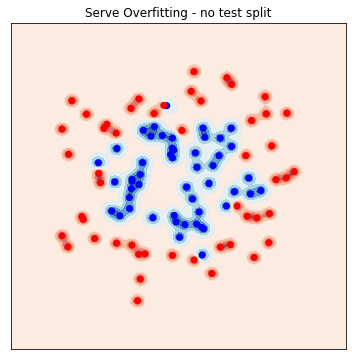

In [4]:
def draw_svm(study, name):
    clf = sklearn.svm.SVC(
        C = study.best_params['C'], 
        kernel=study.best_params['kernel'],
        gamma=study.best_params['gamma']
    )
    clf.fit(X, y)

    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    clf.score(X, y)

draw_svm(study_1, "Serve Overfitting - no test split")

### With train test split



In [5]:
from sklearn.model_selection import train_test_split

def objective(trial):
    classifier_obj = create_clf(trial)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.33, random_state=42)
    
    classifier_obj.fit(X_train, y_train)
    return classifier_obj.score(X_test, y_test)

study_2 = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=0)
)
study_2.optimize(objective, 
               n_trials=200,
               timeout=5 # in [s]
              )

print(study_2.best_params)

{'classifier': 'SVC', 'C': 1.0, 'kernel': 'rbf', 'gamma': 15.188746470640256}


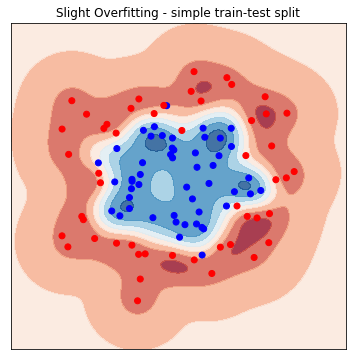

In [6]:
draw_svm(study_2, "Slight Overfitting - simple train-test split")

### Cross-Validation

In [7]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    classifier_obj = create_clf(trial)
    scores = cross_val_score(classifier_obj, X, y, cv=2)
    return np.mean(scores)

study_3 = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=0)
)
study_3.optimize(objective, 
               n_trials=200,
               timeout=5 # in [s]
              )

print(study_3.best_params)

{'classifier': 'SVC', 'C': 1.0, 'kernel': 'rbf', 'gamma': 2.392098915760648}


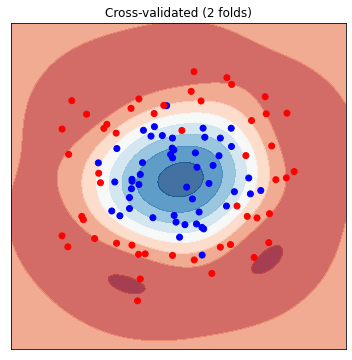

In [8]:
draw_svm(study_3, "Cross-validated (2 folds)")

In [10]:
def objective(trial):
    classifier_obj = create_clf(trial)
    scores = cross_val_score(classifier_obj, X, y, cv=5)
    return np.mean(scores)

study_4 = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=0)
)
study_4.optimize(objective, 
               n_trials=200,
               timeout=5 # in [s]
              )

print(study_4.best_params)

{'classifier': 'SVC', 'C': 1.0, 'kernel': 'rbf', 'gamma': 0.7853028541092179}


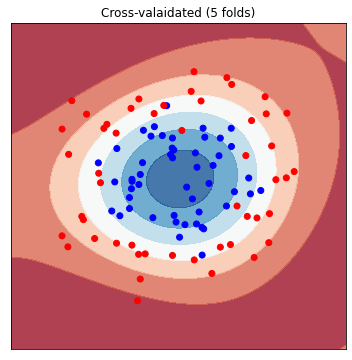

In [11]:
draw_svm(study_4, "Cross-valaidated (5 folds)")

# Optuna - visualization

In [25]:
def create_clf(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC",])
    
    if classifier_name == "SVC":
        gamma = 'scale'
        # <--- C, kernel
        C = trial.suggest_float("C", 1e-3, 1e4, log=True)
        kernel = trial.suggest_categorical("kernel", ['rbf', 'linear'])
        
        if kernel  in ["rbf", "poly", "sigmoid"]:
            gamma = trial.suggest_float('gamma', 1e-5, 10, log=True)
            
        classifier_obj = sklearn.svm.SVC(C=C, kernel=kernel, gamma=gamma)
    else:
        raise NotImplementedError('¯\_(ツ)_/¯')
    
    return classifier_obj

def objective(trial):
    classifier_obj = create_clf(trial)

    scores = cross_val_score(classifier_obj, X, y, cv=5)
    return np.mean(scores)

study_5 = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.RandomSampler(seed=0)
)
study_5.optimize(objective, 
               n_trials=200,
               timeout=5 # in [s]
              )


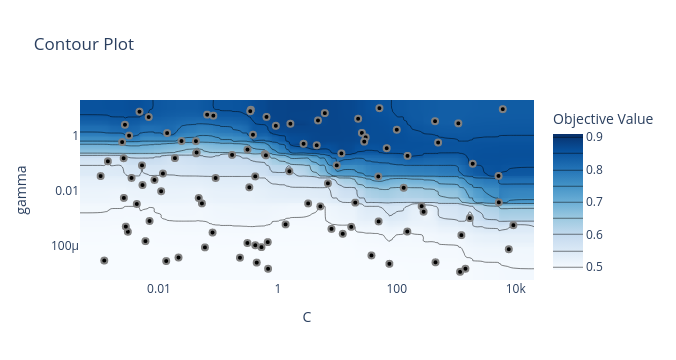

In [26]:
optuna.visualization.plot_contour(study_5, params=['gamma', 'C'])

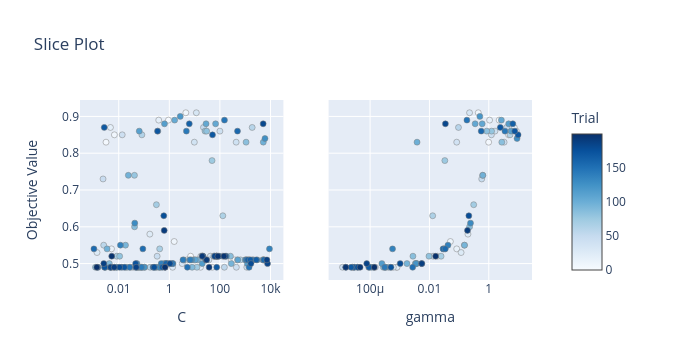

In [34]:
optuna.visualization.plot_slice(study_5, params=["C", "gamma"])

# TASK [2b]
Optimize SVM (use X,y as training & holdout data)

$ \text{kernel} \in \{\text{linear, poly, rbf, sigmoid}\} $

$ \text{C} \in \langle 1e-10, 1e4\rangle $  (use log sampling)

$ \text{gamma} \in \langle1e-5, 500\rangle $ (use log sampling)

$ \text{coef0} \in \langle-10, 10\rangle $

$ \text{degree} \in \langle-2, 4\rangle $

In [44]:
def objective(trial):
    ???
    
study_n = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=0)
)

study_n.optimize(objective, 
               n_trials=200,
               timeout=5 # in [s]
              )

print(study_n.best_params)

{'classifier': 'SVC', 'C': 8.230779405732822, 'kernel': 'poly', 'gamma': 0.35404981912661504, 'coef0': 0.5860411718521272, 'degree': 3}


In [ ]:
clf = sklearn.svm.SVC(
        C = study_n.best_params['C'], 
        kernel=study_n.best_params['kernel'],
        gamma=study_n.best_params['gamma'],
        coef0=study_n.best_params['coef0'],
        degree=study_n.best_params['degree']
    )
clf.fit(X, y)

fig, ax = plt.subplots(1, 1, figsize=(6,6))

if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Expected Output:')
clf.score(X, y)

# Task 2: [2b]
Compute the cross-validated accuracy of this classifier.